# Federal University of Pampa <www.unipampa.edu.br>
# Course: Deep Learning
### Author: Brenda Silveira, Renata Ribeiro e Sandro Camargo <sandrocamargo@unipampa.edu.br>
### Blood Cell Classification using Convolutional Neural Networks
### Dataset: https://www.kaggle.com/datasets/paultimothymooney/blood-cells?resource=download


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/renata-brenda/*.zip /content
!unzip -n /content/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

Loading libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint

Defining image parameters

In [4]:
np.random.seed(1)
# Original images (640x480) needs more hardware resources
# Images can be resized in order to need less hardware resources
image_width = 256 #640 
image_height = 192 #480
batch_size = 128

Loading image sets

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset2-master/dataset2-master/images/TRAIN',
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(image_width, image_height),
  batch_size=batch_size)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset2-master/dataset2-master/images/TRAIN',
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(image_width, image_height),
  batch_size=batch_size)


Found 9957 files belonging to 4 classes.
Using 1991 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 256, 192, 3)
(128,)


Scaling the inputs in [0,1] range and presenting the input and output dataset dimensions

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9875818


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Inspecting the training set

Showing some samples and their labels

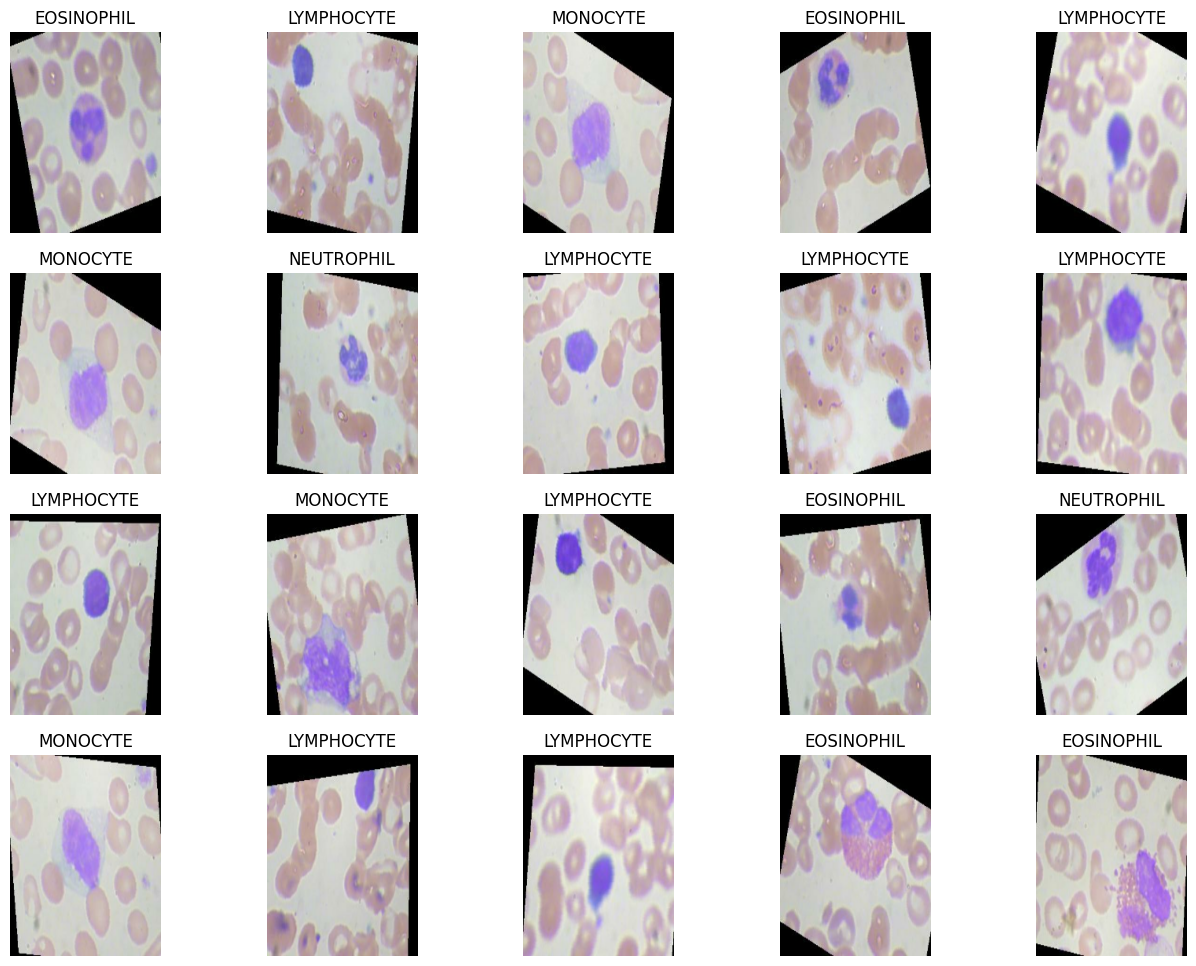

In [12]:
plt.figure(figsize=(16, 12))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


Creating and training the model


In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(80, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(40, activation='relu'),  
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(4)
])

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy','sparse_categorical_crossentropy']
)

mc = ModelCheckpoint('/content/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  verbose=1,
  epochs=100,
  callbacks=mc
)

model.summary()

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 1.3874 - accuracy: 0.2429 - sparse_categorical_crossentropy: 5.4484
Epoch 1: val_accuracy improved from -inf to 0.25917, saving model to /content/best_model.h5
63/63 [==============================] - 41s 396ms/step - loss: 1.3874 - accuracy: 0.2429 - sparse_categorical_crossentropy: 5.4484 - val_loss: 1.3862 - val_accuracy: 0.2592 - val_sparse_categorical_crossentropy: 4.3010
Epoch 2/100
62/63 [============================>.] - ETA: 0s - loss: 1.3869 - accuracy: 0.2671 - sparse_categorical_crossentropy: 5.5198
Epoch 2: val_accuracy improved from 0.25917 to 0.30236, saving model to /content/best_model.h5
63/63 [==============================] - 8s 132ms/step - loss: 1.3869 - accuracy: 0.2678 - sparse_categorical_crossentropy: 5.5161 - val_loss: 1.3846 - val_accuracy: 0.3024 - val_sparse_categorical_crossentropy: 5.7984
Epoch 3/100
62/63 [============================>.] - ETA: 0s - loss: 1.2952 - accuracy: 0.3769 - spa

Plotting the loss function on training and validation set.

The best value for epochs is when the validation loss starts to increase.

---



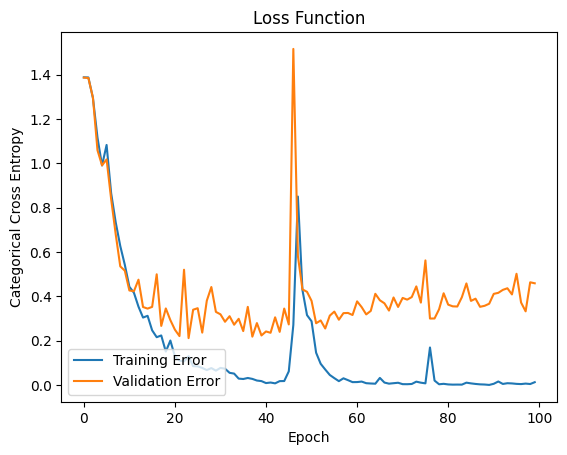

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Function')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epoch')
plt.legend(['Training Error','Validation Error'], loc='lower left')
plt.savefig("trainingerror.pdf")
plt.show()

Plotting the classification accuracy on training and validation sets

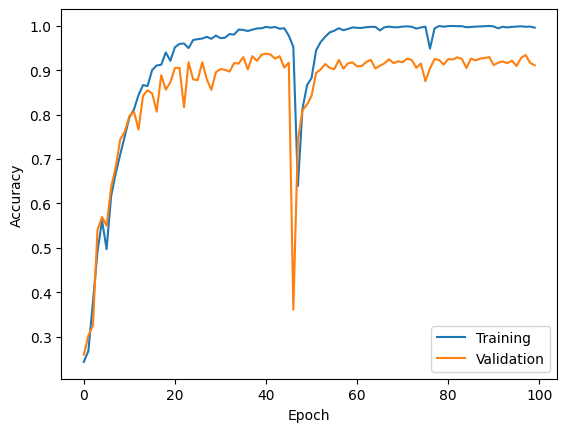

Training Categorical Accuracy: 0.996
Validation Categorical Accuracy: 0.9111


In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'], loc='lower right')
plt.savefig("trainingaccuracy.pdf")
plt.show()
print("Training Categorical Accuracy:", round(history.history['accuracy'][-1],4))
print("Validation Categorical Accuracy:", round(history.history['val_accuracy'][-1],4))

In [16]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset2-master/dataset2-master/images/TEST',
  validation_split=None,
  seed=1,
  image_size=(image_width, image_height),
  batch_size=1)

Found 2487 files belonging to 4 classes.


In [17]:
#loading the best model
model = tf.keras.models.load_model('/content/best_model.h5')
test_predictions = model.predict(test_ds)

predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, model.predict(x, verbose=0).argmax(axis=1)])
  labels = np.concatenate([labels, y])

tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
print("Accuracy Score:", accuracy_score(labels, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(labels, predictions))
print("\nClassification Report:\n", classification_report(labels, predictions, target_names=class_names))

2487/2487 [==============================] - 7s 3ms/step
Accuracy Score: 0.8323281061519904

Confusion Matrix:
 [[449   8   4 162]
 [  0 615   4   1]
 [  5   0 465 150]
 [ 68   3  12 541]]

Classification Report:
               precision    recall  f1-score   support

  EOSINOPHIL       0.86      0.72      0.78       623
  LYMPHOCYTE       0.98      0.99      0.99       620
    MONOCYTE       0.96      0.75      0.84       620
  NEUTROPHIL       0.63      0.87      0.73       624

    accuracy                           0.83      2487
   macro avg       0.86      0.83      0.84      2487
weighted avg       0.86      0.83      0.84      2487



Evaluates performance on test set
Presents the classification accuracy

Summarizing the performance on training set


Confusion Matrix Heatmap

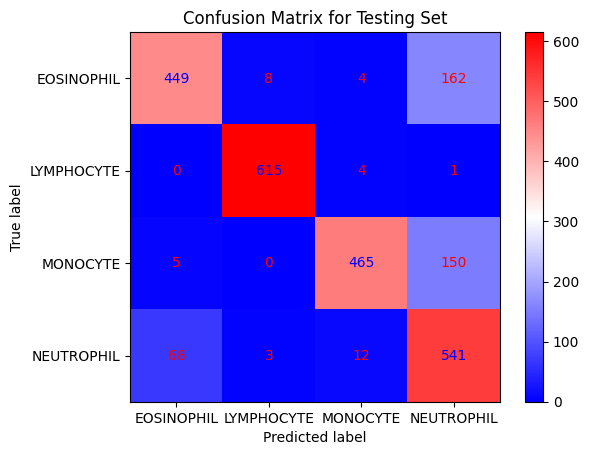

In [18]:
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="bwr")
plt.title('Confusion Matrix for Testing Set')
plt.savefig("confusionmatrix.pdf")
plt.show()

Reporting some misclassified samples 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 17.1 MB/s eta 0:00:00


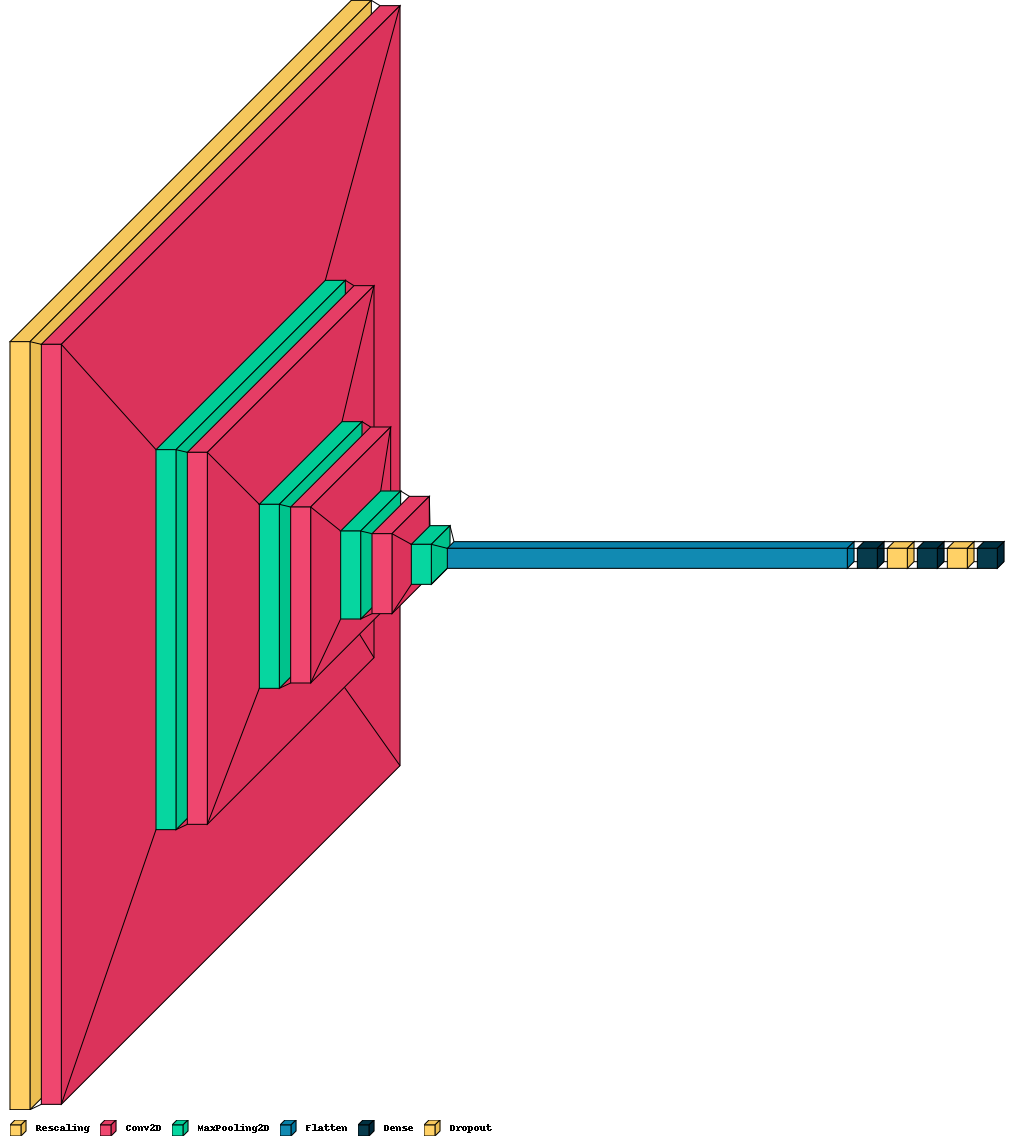

In [19]:
# plota a arquitetura da rede convolucional
!pip install visualkeras
import visualkeras 
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

Printing packages and versions

In [20]:
!python --version
print("Pandas, versão ", pd.__version__)
print("Numpy, versão ", np.__version__)
print("Tensorflow, versão ", tf.__version__)
import matplotlib
import sklearn
import keras
print("Matplotlib, versão ", matplotlib.__version__)
print("Sklearn, versão ", sklearn.__version__)
print("Keras, versão ", keras.__version__)

Python 3.10.11
Pandas, versão  1.5.3
Numpy, versão  1.22.4
Tensorflow, versão  2.12.0
Matplotlib, versão  3.7.1
Sklearn, versão  1.2.2
Keras, versão  2.12.0
